<a href="http://cocl.us/pytorch_link_top">
    <img src="https://cocl.us/Pytorch_top" width="750" alt="IBM 10TB Storage" />
</a>

<img src="https://ibm.box.com/shared/static/ugcqz6ohbvff804xp84y4kqnvvk3bq1g.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Convolutional Neural Network with Small Images</h1> 

<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>

<hr>

<h2>Preparation</h2>

In [1]:
# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

Define the function <code>plot_channels</code> to plot out the kernel parameters of  each channel 

In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function <code>plot_parameters</code> to plot out the kernel parameters of each channel with Multiple outputs . 

In [3]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function <code>plot_activation</code> to plot out the activations of the Convolutional layers  

In [4]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

Define the function <code>show_data</code> to plot out data samples as images.

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

<!--Empty Space for separating topics-->

<h2 id="Makeup_Data">Get the Data</h2> 

We create a transform to resize the image and convert it to a tensor .

In [6]:
# The composer for resizeing the image

IMAGE_SIZE = 8
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.

In [7]:
# Make the training 

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Load the testing dataset by setting the parameters train  <code>False</code>.

In [8]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.

In [10]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.

<img src="https://ibm.box.com/shared/static/7024mnculm8w2oh0080y71cpa48cib2k.png" width="550" alt="MNIST data image">

Print out the fourth label 

In [11]:
# The label for the fourth data element

train_dataset[3][1]

1

Plot the fourth sample 

AttributeError: 'int' object has no attribute 'item'

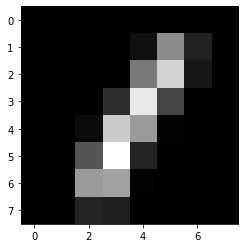

In [12]:
# The image for the fourth data element

show_data(train_dataset[3])

The fourth sample is a "1".

<!--Empty Space for separating topics-->

<h2 id="CNN">Build a Convolutional Neural Network Class</h2>

Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.

In [13]:
# Build the convolutional Neural Network Class

class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 2 * 2, 10)
    
    # Prediction
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = self.relu1(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = self.relu2(z2)
        out = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out

<!--Empty Space for separating topics-->

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2> 

There are 16 output channels for the first layer, and 32 output channels for the second layer 

In [14]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

Plot the model parameters for the kernels before training the kernels. The kernels are initialized randomly.

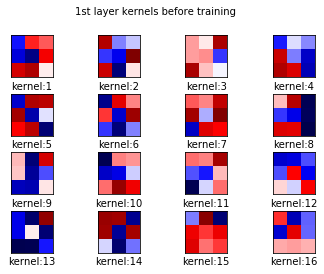

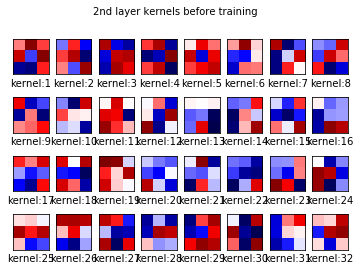

In [15]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

Define the loss function, the optimizer and the dataset loader 

In [16]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**

In [17]:
# Train the model

n_epochs = 3
loss_list = []
accuracy_list = []
N_test = len(validation_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        loss_list.append(loss.data)
        
train_model(n_epochs)

<!--Empty Space for separating topics-->

<h2 id="Result">Analyze Results</h2> 

Plot the loss and accuracy on the validation data:

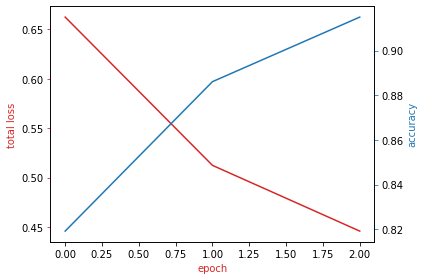

In [18]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers 

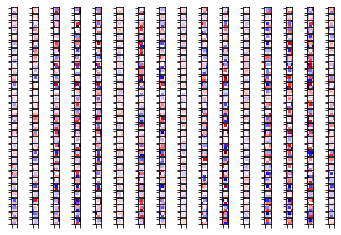

In [19]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Consider the following sample 

AttributeError: 'int' object has no attribute 'item'

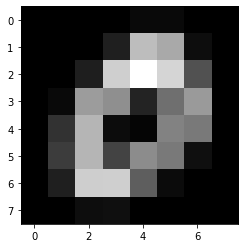

In [20]:
# Show the second image

show_data(train_dataset[1])

Determine the activations 

In [21]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 

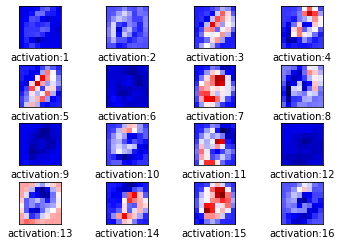

In [22]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function 

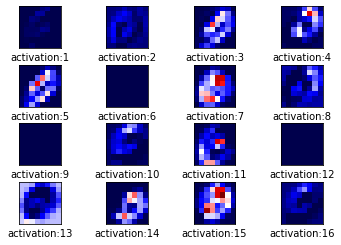

In [23]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.

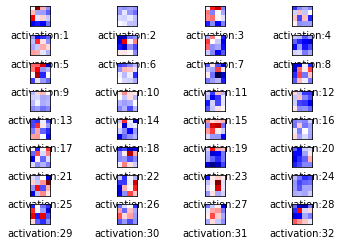

In [24]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu  

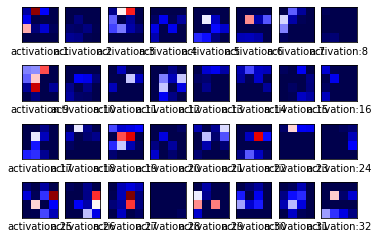

In [25]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

We can  see the result for the third sample 

AttributeError: 'int' object has no attribute 'item'

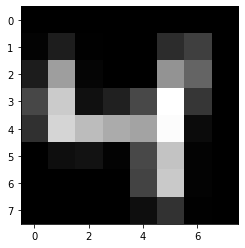

In [26]:
# Show the third image

show_data(train_dataset[2])

In [27]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

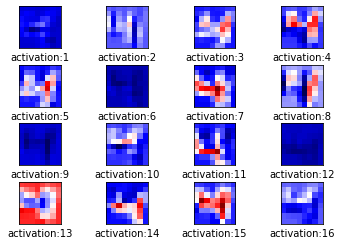

In [28]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

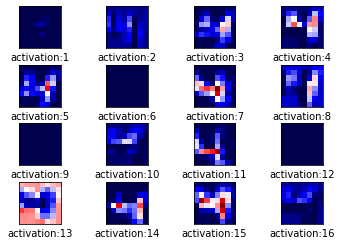

In [29]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

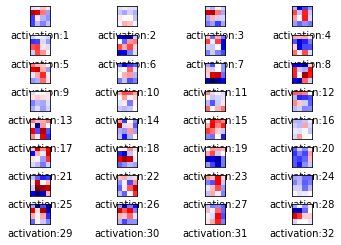

In [30]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

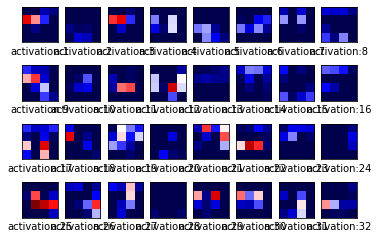

In [31]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

Plot the first five mis-classified samples:

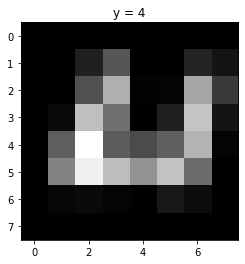

yhat:  tensor([6])


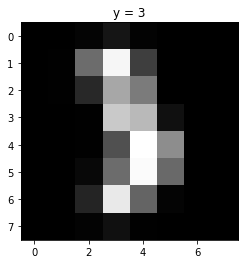

yhat:  tensor([1])


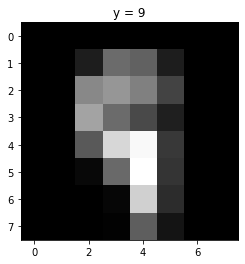

yhat:  tensor([4])


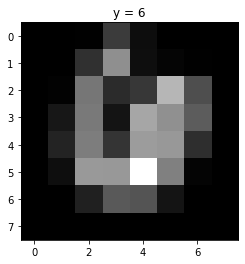

yhat:  tensor([4])


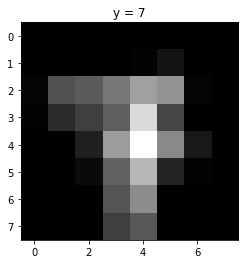

yhat:  tensor([9])


In [32]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

<!--Empty Space for separating topics-->

<a href="http://cocl.us/NotebooksPython101bottom">
    <img src="https://ibm.box.com/shared/static/irypdxea2q4th88zu1o1tsd06dya10go.png" width="750" alt="course Python 101"/>
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

Thanks to Magnus <a href="http://www.hvass-labs.org/">Erik Hvass Pedersen</a> whose tutorials helped me understand convolutional Neural Network

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.